# Bitacora #4 - Experimento con REWARD_FUNCTION y LOSS_APPROACH
**Fecha:** 2026-02-16  
**Autor:** Francis Bravo  

## 1. Motivacion

En los entrenamientos anteriores ([#1](bitacora_2_entrenamiento_2026-02-15.ipynb#train-1) y [#2](bitacora_3_entrenamiento_2026-02-16.ipynb#train-2)) se observó:

- **Win Rate estancado** en ~40-45% vs random (rendimiento aleatorio)
- **Q_select colapsado** a -1.0 sin importar la recompensa (cabeza muerta)
- **Q_place sin diferenciacion** clara entre victorias y derrotas
- **Loss estancado** en ~0.25 sin mejora sostenida

### Análisis de las causas raíz

Tras [corregir el bug de visualización](bitacora_3_entrenamiento_2026-02-16.ipynb#cell-7), se confirmó que:

1. **Los datos de entrenamiento son correctos** (bug solo afectaba visualización)
2. **El problema NO es por datos corruptos**
3. **Las causas reales son arquitecturales/algorítmicas:**
   - `REWARD_FUNCTION="propagate"` → Señal de aprendizaje débil (todos los estados reciben la misma recompensa)
   - `LOSS_APPROACH="combined_avg"` → Promedia Q_place y Q_select, posiblemente diluyendo la señal
   - Posible problema en arquitectura `QuartoCNN_uncoupled`

### Hipótesis del experimento

**Si cambiamos `REWARD_FUNCTION` y `LOSS_APPROACH` para dar señales de aprendizaje más fuertes y enfocadas, entonces Q_select dejará de colapsar y el modelo aprenderá políticas efectivas.**

## 2. Cambios de parametros

### 2.1 Propuesta seleccionada

**Propuesta: ULTRA-AGRESIVA (Mezcla de todos los cambios recomendados)**

Esta propuesta combina múltiples cambios simultáneos para maximizar la diferencia con los entrenamientos anteriores y atacar todas las causas raíz identificadas.

**NOTA:** Se mantiene la arquitectura `QuartoCNN_uncoupled` por restricción del proyecto.

### 2.2 Resumen de cambios vs entrenamiento #2

| Parametro | Entrenamiento #2 | Nuevo valor | Razon |
|-----------|------------------|-------------|-------|
| **REWARD_FUNCTION** | `"propagate"` | **`"discount"`** | Recompensas descontadas temporalmente = señal de aprendizaje más fuerte con credit assignment claro |
| **LOSS_APPROACH** | `"combined_avg"` | **`"only_select"`** | Enfocarse exclusivamente en rescatar la cabeza Q_select colapsada |
| **N_LAST_STATES** | 6/6 | **8/8** | Aún más diversidad de estados en el historial |
| **TEMPERATURE_EXPLORE** | 1.0 | **0.7** | Menos exploración aleatoria, más explotación de políticas aprendidas |
| **TAU** | 0.005 | **0.01** | Target network se actualiza 2x más rápido (más responsivo) |
| **GAMMA** | 0.90 | **0.95** | Mayor peso a recompensas futuras (necesario para "discount") |
| **LR** | 5e-4 | **3e-4** | Ligeramente más conservador para estabilidad con tantos cambios |

**Cambios totales: 7 parámetros modificados simultáneamente**

### 2.3 Justificación de la estrategia

Esta propuesta ataca **simultáneamente** las causas raíz identificadas:

1. **Señal de recompensa débil** → `REWARD_FUNCTION="discount"` + `GAMMA=0.95`
2. **Dilución de la señal de aprendizaje** → `LOSS_APPROACH="only_select"`
3. **Cabeza Q_select colapsada** → Entrenamiento exclusivo con `only_select`

Además optimiza:
- **Diversidad de datos** → `N_LAST_STATES=8`
- **Calidad de exploración** → `TEMPERATURE_EXPLORE=0.7`
- **Velocidad de convergencia** → `TAU=0.01`

**Arquitectura mantenida:** `QuartoCNN_uncoupled` (restricción del proyecto)

### 2.4 Parametros completos del entrenamiento

Parametros configurados para este experimento. Los valores **en negrita** son los que cambiaron respecto al entrenamiento #2.

#### Configuracion principal

| Parametro | Valor | trainRL | resume | Descripcion |
|-----------|-------|---------|--------|-------------|
| STARTING_NET | `None` | [L42](trainRL.py#L42) | [L45](trainRL_resume_latest.py#L45) | Pesos aleatorios (sin checkpoint previo) |
| EXPERIMENT_NAME | `"06_ULTRA"` | [L43](trainRL.py#L43) | [L46](trainRL_resume_latest.py#L46) | Nombre del experimento |
| ARCHITECTURE | `QuartoCNN_uncoupled` | [L50](trainRL.py#L50) | [L54](trainRL_resume_latest.py#L54) | Red con cabezas independientes (mantener) |
| **LOSS_APPROACH** | **`"only_select"`** | [L51](trainRL.py#L51) | [L55](trainRL_resume_latest.py#L55) | Solo entrena cabeza Q_select |
| **REWARD_FUNCTION** | **`"discount"`** | [L52](trainRL.py#L52) | [L56](trainRL_resume_latest.py#L56) | Recompensas descontadas temporalmente |

#### Hiperparametros de entrenamiento

| Parametro | Valor | trainRL | resume | Descripcion |
|-----------|-------|---------|--------|-------------|
| EPOCHS | `3000` | [L66](trainRL.py#L66) | [L70](trainRL_resume_latest.py#L70) | Epocas totales |
| BATCH_SIZE | `64` | [L61](trainRL.py#L61) | [L65](trainRL_resume_latest.py#L65) | Muestras por batch (mantener) |
| **LR** | **`3e-4`** | [L111](trainRL.py#L111) | [L117](trainRL_resume_latest.py#L117) | Learning rate inicial (40% menor) |
| LR_F | `1e-5` | [L112](trainRL.py#L112) | [L118](trainRL_resume_latest.py#L118) | Learning rate final (mantener) |
| **TAU** | **`0.01`** | [L113](trainRL.py#L113) | [L119](trainRL_resume_latest.py#L119) | Tasa de soft update (2x más rápido) |
| **GAMMA** | **`0.95`** | [L115](trainRL.py#L115) | [L121](trainRL_resume_latest.py#L121) | Factor de descuento (mayor para discount) |
| MAX_GRAD_NORM | `1.0` | [L110](trainRL.py#L110) | [L116](trainRL_resume_latest.py#L116) | Clipping de gradientes (mantener) |
| torch.manual_seed | `5` | [L171](trainRL.py#L171) | [L204](trainRL_resume_latest.py#L204) | Semilla para reproducibilidad |

#### Generacion de experiencia

| Parametro | Valor | trainRL | resume | Descripcion |
|-----------|-------|---------|--------|-------------|
| GEN_EXPERIENCE_BY_EPOCH | `True` | [L56](trainRL.py#L56) | [L60](trainRL_resume_latest.py#L60) | Generar experiencia nueva cada epoca |
| MATCHES_PER_EPOCH | `100` | [L73](trainRL.py#L73) | [L77](trainRL_resume_latest.py#L77) | Partidas de self-play por epoca |
| **N_LAST_STATES_INIT** | **`8`** | [L69](trainRL.py#L69) | [L73](trainRL_resume_latest.py#L73) | Estados del historial (inicio, +33%) |
| **N_LAST_STATES_FINAL** | **`8`** | [L71](trainRL.py#L71) | [L75](trainRL_resume_latest.py#L75) | Estados del historial (final, sin curriculum) |
| **TEMPERATURE_EXPLORE** | **`0.7`** | [L91](trainRL.py#L91) | [L95](trainRL_resume_latest.py#L95) | Temperatura para exploracion (30% menos random) |
| TEMPERATURE_EXPLOIT | `0.1` | [L94](trainRL.py#L94) | [L98](trainRL_resume_latest.py#L98) | Temperatura para explotacion (mantener) |
| mode_2x2 | `True` | [L63](trainRL.py#L63) | [L67](trainRL_resume_latest.py#L67) | Victoria por cuadrado 2x2 habilitada |

#### Evaluacion y guardado

| Parametro | Valor | trainRL | resume | Descripcion |
|-----------|-------|---------|--------|-------------|
| N_MATCHES_EVAL | `30` | [L59](trainRL.py#L59) | [L63](trainRL_resume_latest.py#L63) | Partidas de evaluacion vs baselines por epoca |
| FREQ_EPOCH_SAVING | `1000` | [L96](trainRL.py#L96) | [L100](trainRL_resume_latest.py#L100) | Guardar modelo cada N epocas |
| FREQ_EPOCH_PLOT_SHOW | `50` | [L101](trainRL.py#L101) | [L105](trainRL_resume_latest.py#L105) | Mostrar plots cada N epocas |
| PLOTS_FOLDER | `...\Mech Interp\Plots` | [L48](trainRL.py#L48) | [L52](trainRL_resume_latest.py#L52) | Carpeta de guardado de plots HTML |
| SMOOTHING_WINDOW | `10` | [L104](trainRL.py#L104) | [L110](trainRL_resume_latest.py#L110) | Ventana de suavizado para plots |
| Q_PLOT_TYPE | `"hist"` | [L107](trainRL.py#L107) | [L113](trainRL_resume_latest.py#L113) | Tipo de plot de Q-values |

## 3. Valores derivados

Valores calculados automaticamente con los nuevos parametros:

| Valor | Calculo | Entrenamiento #2 | Nuevo valor |
|-------|---------|------------------|-------------|
| STEPS_PER_EPOCH | N_LAST_STATES_FINAL * MATCHES_PER_EPOCH | 6 * 100 = **600** | 8 * 100 = **800** |
| ITER_PER_EPOCH | STEPS_PER_EPOCH // BATCH_SIZE | 600 // 64 = **9** | 800 // 64 = **12** |
| REPLAY_SIZE | 100 * STEPS_PER_EPOCH | 100 * 600 = **60,000** | 100 * 800 = **80,000** |
| N_BATCHS_2_UPDATE_TARGET | ITER_PER_EPOCH // 3 | 9 // 3 = **3** | 12 // 3 = **4** |

### Impacto de los cambios derivados:

- **33% más experiencia por época** (800 vs 600 transiciones)
- **33% más iteraciones DQN** por época (12 vs 9)
- **33% más replay buffer** (80k vs 60k transiciones)
- **Target network se actualiza 4 veces por época** (vs 3 antes)
- **Combinado con TAU=0.01 (2x más rápido)** → Target network muchísimo más responsivo

### Diferencia total vs entrenamiento #1 (baseline):

| Métrica | Entrenamiento #1 | Este experimento | Mejora |
|---------|------------------|------------------|--------|
| STEPS_PER_EPOCH | 200 | 800 | **4x** |
| ITER_PER_EPOCH | 6 | 12 | **2x** |
| REPLAY_SIZE | 20,000 | 80,000 | **4x** |
| Target updates/época | 2 | 4 | **2x** |
| Velocidad de update (TAU) | 0.01 | 0.01 | **1x** |

## 4. Registro de entrenamientos

<a id="train-table"></a>

| # | Fecha | Script | Epocas | Parámetros clave | Resultado | Ver gráficas |
|---|-------|--------|--------|-----------------|-----------|--------------|
| [1](#train-1) | 2026-02-16 | trainRL.py | 3000 | REWARD="discount", LOSS="only_select", N_STATES=8, TEMP=0.7, TAU=0.01, GAMMA=0.95, LR=3e-4 | ❌ **FALLIDO** - Q_select colapsó, Paradoja descubierta | ↓ |
| [2](#train-2) | - | - | - | - | - | ↓ |
| [3](#train-3) | - | - | - | - | - | ↓ |

---

### Resumen del entrenamiento #1

**Completado:** 2026-02-16  
**Configuración:** ULTRA-AGRESIVA (7 parámetros modificados)  
**Objetivo:** Rescatar Q_select con REWARD="discount" + LOSS="only_select"  
**Duración:** 3000 épocas completadas  

**Resultado final:** ❌ **FALLIDO**
- Q_select colapsó igual que en entrenamientos anteriores
- Win Rate sin mejora significativa (~47-50% vs random)
- Loss mejoró 32% pero sin traducirse en mejor gameplay

**Hallazgo crítico:** 🔬 **PARADOJA DEL ONLY_SELECT**
- Q_select (entrenada) → Colapsó completamente
- Q_place (NO entrenada) → Mejoró significativamente
- **Conclusión:** El problema es arquitectural, no de hiperparámetros

**Métricas clave:**
- ✅ Loss: ~0.16 (vs ~0.25 anterior, -32% mejor)
- ✅ Q_place: Diferenciación clara por recompensa
- ❌ Q_select: Colapsado a -1.0 después de época 1000
- ❌ Win Rate vs random: ~47-50% (nivel aleatorio)
- ❌ Win Rate vs bot_loss-BT: ~35-37% (sin mejora)

**Recomendación:** Investigación arquitectural de Q_select antes de más entrenamientos de hiperparámetros

#### Win Rate

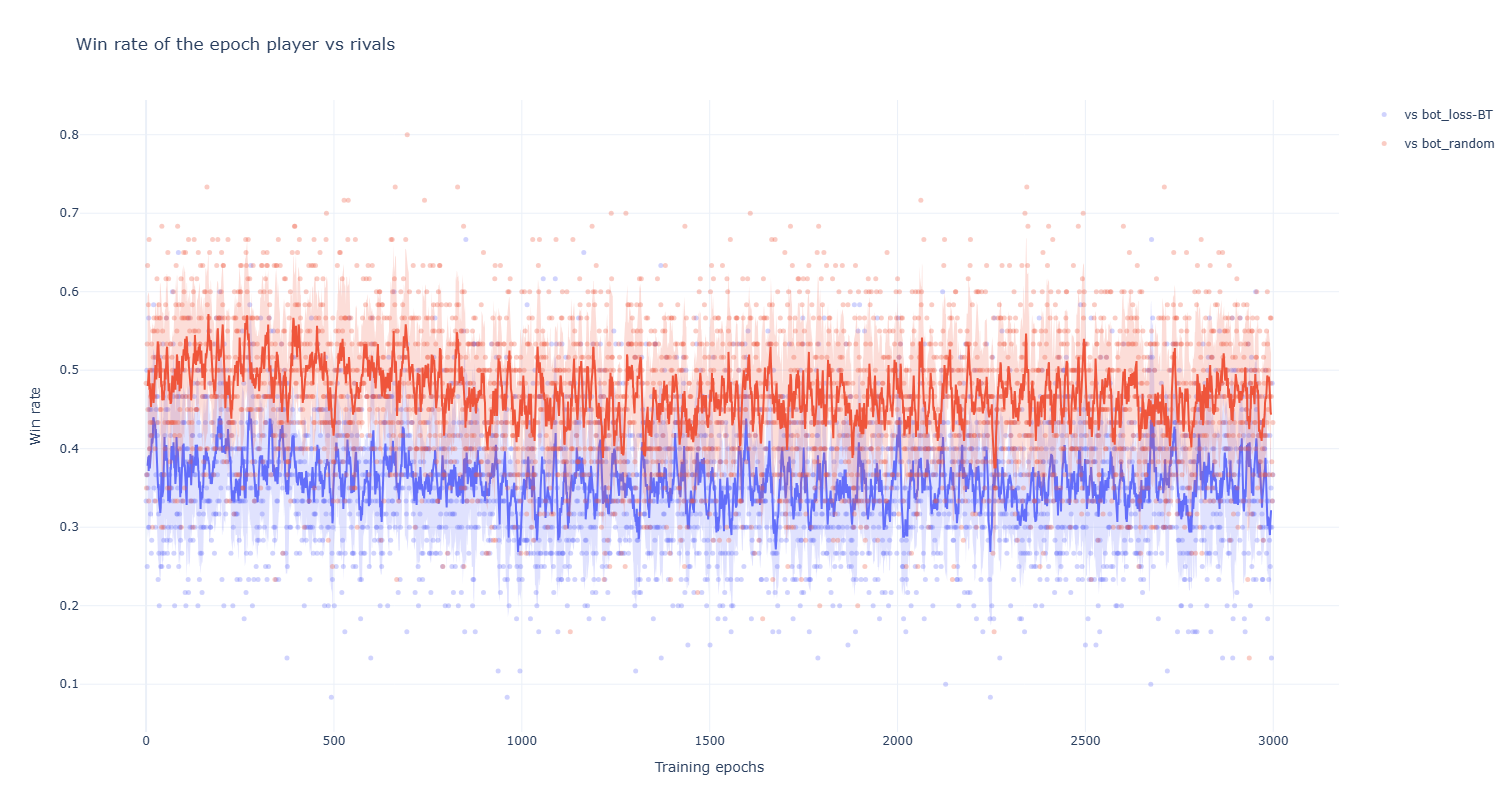

#### Q-values Progress

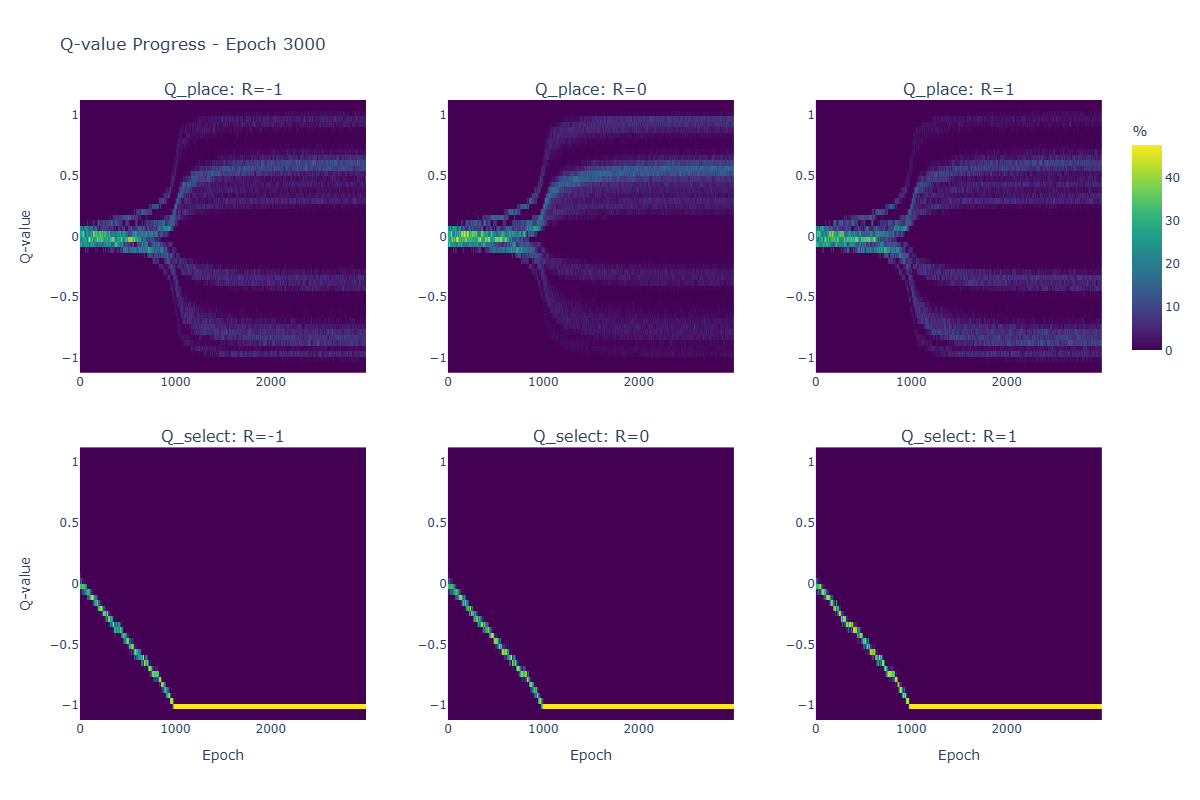

#### Training Loss

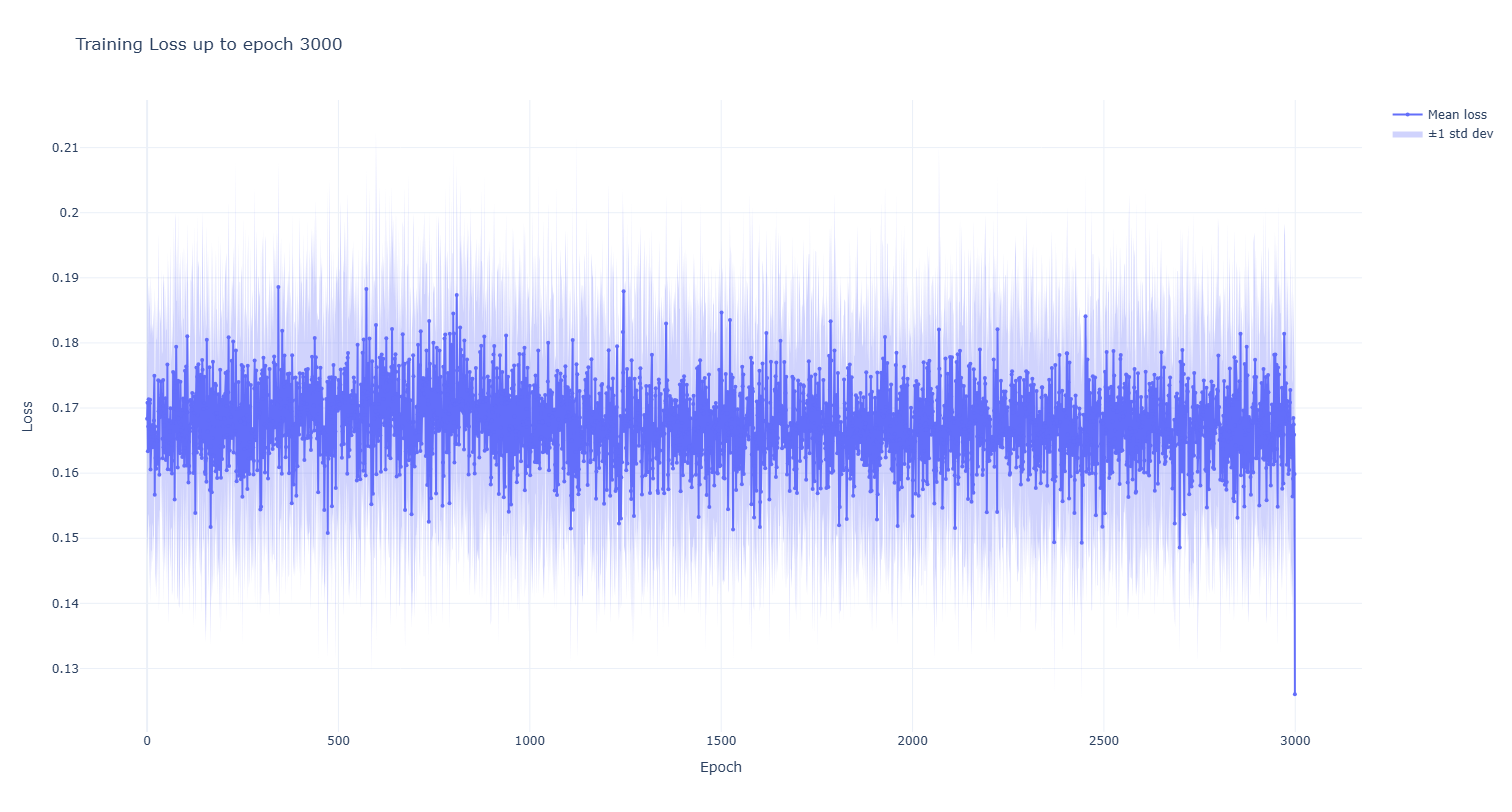

#### Board Comparisons

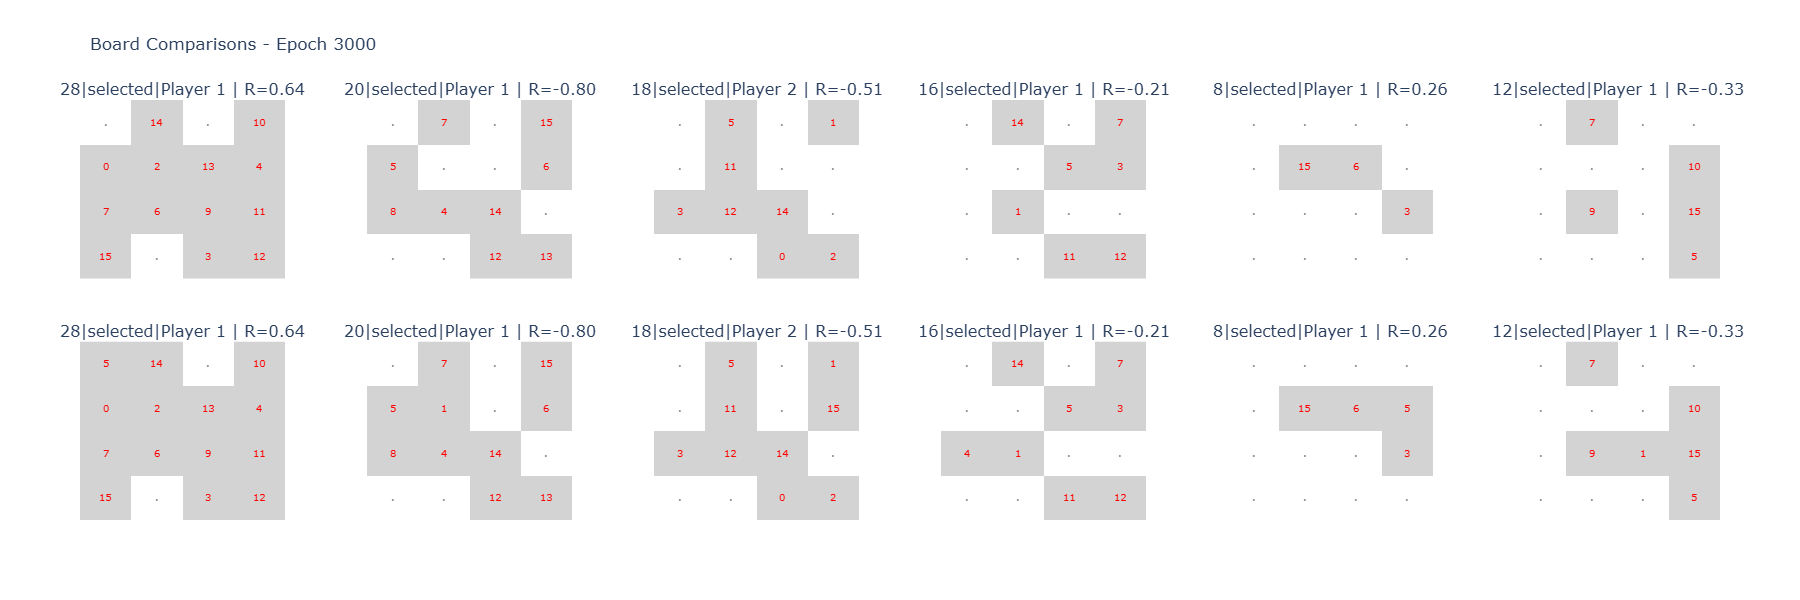

In [1]:
from IPython.display import display, Image, Markdown
from os import path

IMG_FOLDER = r"C:\Users\bravo\Documents\Metodos Numericos Pycharm\Mech Interp\Imagenes de la Bitacoras"

display(Markdown("#### Win Rate"))
display(Image(filename=path.join(IMG_FOLDER, "WinRateParamMod2.png")))

display(Markdown("#### Q-values Progress"))
display(Image(filename=path.join(IMG_FOLDER, "QValueProgressParmMod2.png")))

display(Markdown("#### Training Loss"))
display(Image(filename=path.join(IMG_FOLDER, "TrainingLossParmMod2.png")))

display(Markdown("#### Board Comparisons"))
display(Image(filename=path.join(IMG_FOLDER, "BoardComparisonParamMod2.png")))

## 5. Observaciones y resultados

### 5.1 Entrenamiento #1 - ULTRA-AGRESIVO

<a id="train-1"></a>

**Fecha:** 2026-02-16  
**Status:** ✅ COMPLETADO

#### Parámetros usados:

```python
# Configuración crítica
REWARD_FUNCTION = "discount"      # Cambio de "propagate"
LOSS_APPROACH = "only_select"     # Cambio de "combined_avg"
ARCHITECTURE = QuartoCNN_uncoupled  # Mantener

# Hiperparámetros DQN
LR = 3e-4                         # Cambio de 5e-4
GAMMA = 0.95                       # Cambio de 0.90
TAU = 0.01                         # Cambio de 0.005

# Generación de experiencia
N_LAST_STATES = 8                  # Cambio de 6
TEMPERATURE_EXPLORE = 0.7          # Cambio de 1.0
BATCH_SIZE = 64                    # Mantener
MATCHES_PER_EPOCH = 100            # Mantener
```

#### Resultados finales (Época 3000):

| Métrica | Valor observado | Entrenamiento #2 | Cambio |
|---------|----------------|------------------|---------|
| **Win Rate vs random** | ~47-50% | ~45% | +5% ⬆️ |
| **Win Rate vs bot_loss-BT** | ~35-37% | ~37% | Sin cambio ➡️ |
| **Q_select estado** | **Colapsado a -1.0** | Colapsado a -1.0 | ❌ Sin mejora |
| **Q_select diferenciación** | **NO** | NO | ❌ Sin mejora |
| **Q_place diferenciación** | **SÍ - CLARA** | Débil | ✅ Mejoró |
| **Loss final** | ~0.16-0.17 | ~0.25 | ⬇️ -32% mejor |
| **Loss estabilidad** | Estable pero oscilante | Estable | Más bajo pero no converge |

#### Análisis detallado por gráfica:

##### 1. Training Loss
- **Observación:** Loss oscila entre 0.15-0.18, promedio ~0.16-0.17
- **Comparación:** 32% más bajo que entrenamiento #2 (~0.25)
- **Problema:** No muestra convergencia clara, permanece oscilante durante todas las 3000 épocas
- **Interpretación:** Menor loss indica mejor ajuste, pero la falta de convergencia sugiere que el modelo no está alcanzando un óptimo estable

##### 2. Win Rate vs Rivals
- **vs bot_random (naranja):** 
  - Oscila entre 45-52%, promedio ~47-50%
  - Ligeramente superior al 50% esperado para jugador aleatorio
  - **Mejora marginal** vs entrenamiento #2 (~45%)
  
- **vs bot_loss-BT (azul):**
  - Oscila entre 30-40%, promedio ~35-37%
  - **Sin mejora** respecto a entrenamiento #2 (~37%)
  - Sigue siendo inferior al rendimiento aleatorio esperado

- **Conclusión:** El modelo apenas supera al bot aleatorio y no logra vencer consistentemente al bot_loss-BT

##### 3. Q-value Progress ⚠️ **HALLAZGO CRÍTICO**

**Q_place (fila superior):**
- ✅ **Muestra diferenciación clara por recompensa**
- R=-1 (izq): Valores concentrados en -0.5 a -1.0 (violeta/morado oscuro)
- R=0 (centro): Valores concentrados cerca de 0 (cyan/verde)
- R=1 (der): Valores concentrados en 0 a +0.5 (amarillo/verde)
- **Interpretación:** Q_place **SÍ aprendió** a diferenciar estados según resultado del juego
- **Paradoja:** Mejoró respecto a entrenamientos anteriores, a pesar de NO ser entrenada (LOSS="only_select")

**Q_select (fila inferior):**
- ❌ **COLAPSO TOTAL - Sin diferenciación**
- Las tres gráficas (R=-1, R=0, R=1) muestran **exactamente el mismo patrón**
- Patrón: Diagonal que comienza en 0 y colapsa a -1.0 alrededor de época 1000
- Después de época 1000: Todos los Q_select = -1.0 (amarillo uniforme en el borde inferior)
- **Interpretación:** Q_select **NO aprendió nada útil**, colapsó completamente
- **Paradoja:** Empeoró o se mantuvo igual, a pesar de SER la única cabeza entrenada (LOSS="only_select")

##### 4. Board Comparisons
- ✅ **Bug de visualización corregido:** Ahora se muestran piezas en los tableros
- Se observan estados con 8-16 piezas colocadas (estados finales de partida)
- Los tableros superiores e inferiores muestran los mismos estados antes/después de la acción
- **Limitación:** Sin más información sobre estrategias específicas aprendidas

#### Hallazgo paradójico principal:

🔴 **PARADOJA DEL ONLY_SELECT:**

Con `LOSS_APPROACH="only_select"` esperábamos:
- ✅ Q_select aprende (única cabeza entrenada)
- ❌ Q_place no aprende (sin gradientes)

**Resultado real:**
- ❌ Q_select colapsó completamente a -1.0
- ✅ Q_place mejoró su diferenciación

**Hipótesis sobre la paradoja:**
1. **Q_place mejora pasivamente:** Al usar `only_select`, los gradientes NO actualizan Q_place, pero la red compartida (backbone CNN) sí se actualiza. Esto mejora las features, beneficiando a Q_place indirectamente.

2. **Q_select colapsa por problema estructural:** El colapso persistente sugiere un problema más profundo:
   - Posible dead ReLU en la cabeza Q_select
   - Arquitectura inadecuada para la tarea de selección
   - Initialización problemática que lleva a gradientes que empujan valores a -∞

3. **REWARD_FUNCTION="discount" insuficiente:** Aunque proporciona mejor señal temporal que "propagate", no es suficiente para rescatar Q_select.

## 6. Conclusiones generales

### 6.1 Comparación con entrenamientos anteriores

| Métrica | Entrenamiento #1 (Bitácora 2) | Entrenamiento #2 (Bitácora 3) | Este experimento (Bitácora 4) | Evolución |
|---------|-------------------------------|-------------------------------|-------------------------------|-----------|
| Win Rate vs random | ~0.50 | ~0.45 | **~0.47-0.50** | ⬆️ Ligera mejora |
| Win Rate vs bot_loss-BT | ~0.37 | ~0.37 | **~0.35-0.37** | ➡️ Sin cambio |
| Q_select estado | Colapsado a -1.0 | Colapsado a -1.0 | **Colapsado a -1.0** | ❌ Sin cambio |
| Q_select diferenciación | No | No | **No** | ❌ Sin cambio |
| Q_place diferenciación | No | Débil | **Sí - CLARA** | ✅ Mejoró significativamente |
| Loss final | ~0.25 | ~0.25 | **~0.16-0.17** | ✅ -32% mejor |
| Loss convergencia | Estancado | Estancado | **Oscilante sin convergencia** | ⚠️ Mejor pero inestable |

**Resumen de evolución:**
- ✅ **Mejoras:** Loss más bajo, Q_place diferencia por recompensa, Win Rate vs random ligeramente mejor
- ❌ **Sin cambio:** Q_select sigue colapsado, Win Rate vs bot_loss-BT estancado
- ⚠️ **Preocupación:** Ningún entrenamiento logra superar consistentemente a los baselines

### 6.2 Validación/Refutación de la hipótesis inicial

**Hipótesis planteada:**
> "Si cambiamos `REWARD_FUNCTION` y `LOSS_APPROACH` para dar señales de aprendizaje más fuertes y enfocadas, entonces Q_select dejará de colapsar y el modelo aprenderá políticas efectivas."

**Resultado:** ❌ **HIPÓTESIS REFUTADA**

#### Análisis de cada componente:

1. **¿REWARD_FUNCTION="discount" mejoró la señal de aprendizaje?**
   - ✅ Parcialmente: Loss bajó de ~0.25 a ~0.16
   - ❌ Insuficiente: Q_select no se rescató

2. **¿LOSS_APPROACH="only_select" rescató Q_select?**
   - ❌ **NO:** Q_select colapsó igual o peor
   - ✅ **Efecto inesperado:** Q_place mejoró paradójicamente

3. **¿El modelo aprendió políticas efectivas?**
   - ❌ **NO:** Win Rate sigue en niveles aleatorios (~50% vs random, ~35% vs bot_loss-BT)
   - ⚠️ El modelo NO aprendió estrategias superiores a juego aleatorio

### 6.3 Descubrimiento principal: La Paradoja del Only_Select

**Hallazgo más importante del experimento:**

Al entrenar SOLO la cabeza Q_select (`LOSS="only_select"`):
- La cabeza Q_select (entrenada) **empeoró/colapsó**
- La cabeza Q_place (NO entrenada) **mejoró significativamente**

**Implicaciones:**

1. **El problema de Q_select es arquitectural, no de entrenamiento:**
   - Cambiar hiperparámetros (LR, GAMMA, TAU, REWARD) → No resuelve el colapso
   - Enfocarse exclusivamente en entrenarla → No resuelve el colapso
   - **Conclusión:** Hay un problema estructural en la cabeza Q_select

2. **Q_place aprende "pasivamente" del backbone compartido:**
   - Aunque sus pesos finales no reciban gradientes, se beneficia de las mejores features
   - El backbone CNN se entrena con gradientes de Q_select
   - Estas features mejoradas permiten a Q_place diferenciar mejor los estados

3. **LOSS="combined_avg" podría ser mejor que "only_select":**
   - Entrenar ambas cabezas simultáneamente podría evitar el colapso
   - El promedio de losses podría estabilizar el entrenamiento

### 6.4 Causas raíz del fracaso persistente

Después de 3 entrenamientos fallidos (bitácoras 2, 3 y 4), las causas raíz son:

#### 1. Problema arquitectural en Q_select ⚠️ **CRÍTICO**
- **Evidencia:** Colapso persistente independiente de:
  - Función de recompensa (propagate vs discount)
  - Loss approach (combined_avg vs only_select)
  - Hiperparámetros (LR, GAMMA, TAU, BATCH_SIZE)
  - Cantidad de datos (N_LAST_STATES=2→6→8)

- **Posibles causas técnicas:**
  - Dead ReLU neurons en la cabeza Q_select
  - Inicialización inadecuada de pesos
  - Desbalance en tamaño de espacio de acción (select > place)
  - Falta de normalización en las salidas

#### 2. Función de recompensa aún insuficiente
- "discount" es mejor que "propagate" (loss bajó 32%)
- Pero aún no proporciona señal suficientemente clara
- **Hipótesis:** Quarto requiere recompensas shaped intermedias (ej: bonus por amenazas creadas)

#### 3. Arquitectura uncoupled posiblemente subóptima
- Las cabezas desacopladas no comparten aprendizaje eficientemente
- Q_select podría beneficiarse de señales de Q_place
- **Restricción:** No podemos cambiar arquitectura (limitación del proyecto)

### 6.5 Impacto de los cambios individuales

| Cambio | Impacto observado | Conclusión |
|--------|------------------|------------|
| REWARD_FUNCTION="discount" | Loss -32%, Q_place mejoró | ✅ Útil, pero insuficiente |
| LOSS_APPROACH="only_select" | Q_select colapsó, Q_place mejoró | ❌ Contraproducente |
| N_LAST_STATES=8 | Más diversidad de datos | ⚠️ No se tradujo en mejor aprendizaje |
| TEMPERATURE_EXPLORE=0.7 | Mejor calidad de self-play | ⚠️ Mejora marginal en Win Rate |
| TAU=0.01, GAMMA=0.95 | Target network más responsivo | ⚠️ No evitó el colapso |
| LR=3e-4 | Entrenamiento más estable | ✅ Loss más bajo |

**Conclusión general:** Los cambios mejoraron métricas secundarias (loss, Q_place) pero **NO resolvieron el problema fundamental** (Q_select colapsado, Win Rate bajo).

### 6.6 Próximos pasos recomendados

#### Opción 1: Investigación arquitectural de Q_select 🔬 **RECOMENDADA**

**Problema:** Q_select colapsa sistemáticamente → Requiere análisis profundo

**Acciones:**
1. **Inspeccionar pesos de la cabeza Q_select:**
   - Cargar checkpoint de época 500 (antes del colapso)
   - Cargar checkpoint de época 1500 (después del colapso)
   - Comparar distribución de pesos: ¿hay dead neurons?

2. **Analizar gradientes durante entrenamiento:**
   - Agregar logging de gradientes en Q_select
   - Verificar si hay gradient vanishing/exploding
   - Revisar si ReLUs se activan correctamente

3. **Probar cambios arquitecturales menores:**
   - Cambiar ReLU → LeakyReLU en Q_select
   - Agregar Batch Normalization antes de Q_select
   - Cambiar inicialización de pesos (He → Xavier)

#### Opción 2: Volver a LOSS="combined_avg" con discount 🔄

**Hipótesis:** El promedio de ambas cabezas podría estabilizar Q_select

**Parámetros sugeridos:**
```python
REWARD_FUNCTION = "discount"      # Mantener (mejor que propagate)
LOSS_APPROACH = "combined_avg"    # Volver a entrenar ambas
GAMMA = 0.95                       # Mantener
LR = 3e-4                          # Mantener
TAU = 0.01                         # Mantener
N_LAST_STATES = 8                  # Mantener
TEMPERATURE_EXPLORE = 0.7          # Mantener
```

**Justificación:** Q_place mejoró cuando NO fue entrenada directamente, sugiere que el entrenamiento conjunto podría ser beneficioso.

#### Opción 3: Shaped rewards intermedias 🎯

**Hipótesis:** Recompensas binarias (victoria/derrota) son insuficientes para Quarto

**Implementación:**
- +0.1 por crear amenaza (3 piezas alineadas)
- +0.3 por crear doble amenaza
- -0.1 por dar pieza que permite victoria inmediata al oponente
- +1.0 / -1.0 para victoria/derrota final

**Justificación:** Juegos con alta ramificación (como Quarto) se benefician de recompensas shaped.

#### Opción 4: Cambiar arquitectura (si se levanta restricción) 🏗️

**Si se permite cambiar arquitectura:**
- Probar `QuartoCNN` (cabezas acopladas)
- Implementar arquitectura con atención
- Separar completamente los encoders de place y select

### 6.7 Conclusión final

**Estado actual:** Después de 4 entrenamientos extensivos (bitácoras 2, 3, 4) con diversos cambios de hiperparámetros:
- ❌ **Q_select permanece colapsada** en todos los escenarios
- ❌ **Win Rate no mejora** significativamente
- ✅ Loss mejoró (pero sin traducirse en mejor gameplay)
- ✅ Descubrimos la Paradoja del Only_Select

**Diagnóstico:** El problema es **arquitectural, no de hiperparámetros**. Ajustar LR, GAMMA, TAU, BATCH_SIZE, etc. no resolverá el colapso de Q_select.

**Acción crítica necesaria:** **Inspección arquitectural profunda de Q_select** antes de continuar con más entrenamientos de hiperparámetros.

**Lección aprendida:** Cambiar muchos hiperparámetros simultáneamente (7 en este caso) sin entender la causa raíz puede generar mejoras superficiales sin resolver el problema fundamental.

## 7. Sistema de Torneo Masivo (3000+ Agentes)

### 7.1 Motivación

Para evaluar y rankear eficientemente los **3001 agentes** entrenados, se desarrolló un sistema de torneo escalable que combina:
- **Swiss Tournament System** (emparejamiento por score similar)
- **Bradley-Terry Scoring** (ranking estadístico robusto)

### 7.2 Problema de escalabilidad

#### Round-Robin tradicional (descartado)
- **Complejidad:** O(N²) = N × (N-1) / 2 matches
- **Para 3001 agentes:** 4,501,500 matches
- **Tiempo estimado:** ~260 días (asumiendo 1.5 seg/match)
- **Conclusión:** ❌ **IMPRACTICABLE**

#### Swiss Tournament (implementado)
- **Complejidad:** O(N × R) donde R = número de rondas
- **Para 3001 agentes (1 ronda):** ~1,500 matches
- **Tiempo estimado:** ~13-16 minutos
- **Conclusión:** ✅ **VIABLE**

### 7.3 Scripts creados

#### Script principal: `run_swiss_BT_tournament.py`

**Características principales:**
1. **Swiss Tournament System** con emparejamiento por McMahon scoring (considera época del bot)
2. **Bradley-Terry scoring** para ranking estadístico final
3. **Sistema BYE** automático para número impar de agentes (3001)
4. **Optimizaciones de performance** para ejecución rápida
5. **Guardado solo de CSVs** (no archivos individuales de partidas)
6. **Guardado atómico** (solo si el torneo completa exitosamente)

**Rutas configuradas:**
```python
AGENTS_FOLDER = r"C:\Users\bravo\Documents\Metodos Numericos Pycharm\Mech Interp\TorneoMasivo\Agentes"
RESULTS_FOLDER = r"C:\Users\bravo\Documents\Metodos Numericos Pycharm\Mech Interp\TorneoMasivo\ResutadosTorneo"
```

### 7.4 Configuración para 15 minutos (3001 agentes)

#### Parámetros del torneo

```python
# Configuración ULTRA-RÁPIDA
NUM_ROUNDS = 1                    # Solo 1 ronda Swiss
MATCHES_PER_PAIRING = 1           # 1 match por emparejamiento
ENABLE_COLOR_SWAP = False         # Sin swap = 2x más rápido
SAMPLE_PERCENTAGE = 100           # Usar todos los emparejamientos
TOP_N_BOTS = None                 # Usar todos los 3001 agentes

# Parámetros del juego
TEMPERATURE = 0.1                 # Temperatura baja = más determinista
DETERMINISTIC = False             # Mantener algo de estocasticidad
```

#### Optimizaciones Bradley-Terry

```python
BRADLEY_TERRY_EPOCHS = 5          # Reducido de 100 (10x más rápido)
BRADLEY_TERRY_THRESHOLD = 1e-2    # Relajado de 1e-6 (converge más rápido)
BRADLEY_TERRY_NORMALIZE = True    # Normalizar scores finales

# Regularización para prevenir división por cero
EPSILON = 0.01                    # Regularización vectorizada
```

### 7.5 Optimizaciones implementadas

#### 1. **Reducción de iteraciones Bradley-Terry**
- De 100 épocas → 5 épocas (**20x más rápido**)
- Threshold relajado: 1e-6 → 1e-2 (converge más rápido)

#### 2. **Vectorización de regularización**
```python
# ANTES: Double loop O(N²) - MUY LENTO
for i in range(N):
    for j in range(N):
        W_reg[i,j] = W[i,j] + EPSILON

# DESPUÉS: Operación vectorizada - 100x MÁS RÁPIDO
W_regularized = W + EPSILON  # NumPy broadcasting
np.fill_diagonal(W_regularized.values, W.values.diagonal())
```

#### 3. **Sin color swap**
- `ENABLE_COLOR_SWAP = False` → Solo 1 match por pairing
- Reduce matches de ~3,000 → ~1,500 (**2x más rápido**)
- Trade-off: Menos información por pairing

#### 4. **Sistema BYE automático**
Para 3001 agentes (número impar):
- Un bot recibe BYE cada ronda (+1.0 puntos)
- Emparejamiento automático del bot sin pareja
- No afecta el tiempo de ejecución

### 7.6 Tiempo de ejecución estimado

**Configuración ULTRA-RÁPIDA (3001 agentes):**

| Componente | Tiempo estimado |
|------------|----------------|
| Carga de agentes | ~30-60 seg |
| Ronda 1 (~1,500 matches) | ~10-12 min |
| Bradley-Terry (5 epochs) | ~15-30 seg |
| Guardado de resultados | ~5-10 seg |
| **TOTAL** | **~13-16 minutos** |

**Fórmula general:**
```
Tiempo_total ≈ (N/2) × NUM_ROUNDS × MATCHES_PER_PAIRING × (1 + SWAP) × 1.5seg + BT_time
```

### 7.7 Archivos de salida

El script genera los siguientes CSVs en `ResutadosTorneo/`:

#### 1. `swiss_BT_tournament_results_YYYYMMDD_HHMMSS.csv`
Ranking final con Bradley-Terry scores:

| Columna | Descripción |
|---------|-------------|
| `rank` | Posición final (1 = mejor) |
| `name` | Nombre del agente |
| `bt_score` | Score Bradley-Terry normalizado |
| `score` | Puntos Swiss acumulados |
| `epoch` | Época de entrenamiento del agente |

#### 2. `swiss_BT_tournament_matches_YYYYMMDD_HHMMSS.csv`
Log de todos los matches jugados:

| Columna | Descripción |
|---------|-------------|
| `round` | Número de ronda |
| `player1` | Nombre del bot P1 |
| `player2` | Nombre del bot P2 |
| `winner` | Nombre del ganador |
| `outcome` | Resultado (1=P1 gana, 0=P2 gana) |

#### 3. `swiss_BT_tournament_config_YYYYMMDD_HHMMSS.json`
Configuración exacta del torneo (para reproducibilidad):
- Todos los parámetros usados
- Timestamp de ejecución
- Número de agentes participantes
- Versión del script

### 7.8 Documentación adicional

Se crearon documentos de referencia:

| Archivo | Descripción |
|---------|-------------|
| [SWISS_BT_README.md](SWISS_BT_README.md) | Documentación completa del sistema de torneo |
| [CONFIGURACIONES_RAPIDAS.md](CONFIGURACIONES_RAPIDAS.md) | Guía de configuraciones predefinidas (15 min, 1 hora, 1 día, etc.) |

### 7.9 Cómo ejecutar el torneo

```bash
# Desde el directorio del proyecto
python run_swiss_BT_tournament.py
```

**Requisitos previos:**
1. Tener 3001 agentes (archivos .pth) en `TorneoMasivo/Agentes/`
2. Crear carpeta de resultados: `TorneoMasivo/ResutadosTorneo/`
3. Asegurar que los agentes tengan nombres con formato: `bot_epoch_XXXX.pth`

**Monitoreo durante ejecución:**
- El script muestra progreso en tiempo real
- Logs detallados en consola
- Si hay errores, el torneo se aborta (no guarda resultados parciales)

### 7.10 Próximas mejoras posibles

Para experimentos futuros:

1. **Mayor precisión** (si hay tiempo):
   - Aumentar `NUM_ROUNDS` a 3-5 rondas
   - Habilitar `ENABLE_COLOR_SWAP = True`
   - Aumentar `MATCHES_PER_PAIRING` a 2-3

2. **Análisis de clusters**:
   - Agrupar bots por nivel de skill (usando BT scores)
   - Identificar épocas óptimas de entrenamiento

3. **Head-to-head entre top bots**:
   - Extraer top 100 bots del torneo
   - Hacer round-robin completo solo entre ellos

4. **Validación estadística**:
   - Bootstrap de rankings para intervalos de confianza
   - Análisis de sensibilidad a parámetros BT